In [1]:
using Pkg
Pkg.activate(@__DIR__)

  Activating environment at `~/Julia/doc/cscs_gpu_course/Project.toml`


In [2]:
using CUDA

# CUDA libraries

In this notebook, I'll explain how to interface with CUDA's libraries in Julia using CUDA.jl, at each level of abstraction.

There are different kinds of CUDA libraries you can use to work with a GPU:

- Driver library: low-level library to work with the NVIDIA driver (what CUDA.jl is built on)
- Runtime library: same functionality, while managing kernel compilation, context allocation, etc (what CUDA.jl offers)
- Application libraries: CUBLAS, CUDNN, CUTENSOR, ...

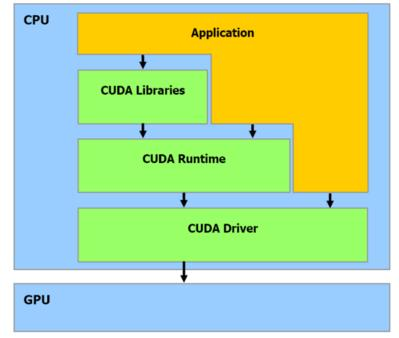

CUDA.jl provides wrappers for several CUDA libraries that are part of the CUDA toolkit:

- Driver library: manage the device, launch kernels, etc.
- CUBLAS: linear algebra
- CURAND: random number generation
- CUFFT: fast fourier transform
- CUSPARSE: sparse arrays
- CUSOLVER: decompositions & linear systems

There's also support for a couple of libraries that aren't part of the CUDA toolkit, but are commonly used:
- CUDNN: deep neural networks
- CUTENSOR: linear algebra with tensors

## Automatic installation & version management
CUDA.jl bundles many CUDA libraries (from the core toolkit as well as external libraries), making them available as artifacts packaged using BinaryBuilder.jl. Selection of these libraries is tricky, as several compatibility requirements need to be taken into account:

- the local NVIDIA driver has a CUDA Toolkit compatibility level
- starting with CUDA 11.0, the driver is forwards-compatible ("Enhanced Compatibility")
- it may be possible to load a more recent driver library to raise the compatibility level ("Forward Compatibility")
- external libraries (CUDNN, CUTENSOR) may have builds for each CUDA Toolkit

You can inspect the result of this exercise by calling `CUDA.versioninfo()`:

In [3]:
CUDA.versioninfo()

CUDA toolkit 11.4, artifact installation
NVIDIA driver 470.82.0, for CUDA 11.4
CUDA driver 11.4

Libraries: 
- CUBLAS: 11.5.4
- CURAND: 10.2.5
- CUFFT: 10.5.1
- CUSOLVER: 11.2.0
- CUSPARSE: 11.6.0
- CUPTI: 14.0.0
- NVML: 11.0.0+470.82.0
- CUDNN: 8.20.2 (for CUDA 11.4.0)
- CUTENSOR: 1.3.0 (for CUDA 11.2.0)

Toolchain:
- Julia: 1.6.3
- LLVM: 11.0.1
- PTX ISA support: 3.2, 4.0, 4.1, 4.2, 4.3, 5.0, 6.0, 6.1, 6.3, 6.4, 6.5, 7.0
- Device capability support: sm_35, sm_37, sm_50, sm_52, sm_53, sm_60, sm_61, sm_62, sm_70, sm_72, sm_75, sm_80

2 devices:
  0: Quadro RTX 5000 (sm_75, 13.646 GiB / 15.744 GiB available)
  1: NVIDIA GeForce GTX TITAN (sm_35, 5.930 GiB / 5.941 GiB available)


The only part that's not being provided by artifcats, is the NVIDIA driver. Since it determines which version of CUDA we can use, it's important to keep this up to date! Only drivers for CUDA 10.1+ are supported, but for performance reasons you should be using a driver for CUDA 11.2 or higher!

If you absolutely need to, you can disable the automatic CUDA selection by starting Julia with the `JULIA_CUDA_USE_BINARYBUILDER` environment variable set to `false`. This will make CUDA.jl look in your local system for all these libraries. That means you are responsible for ensuring compatibility between the driver, toolkit, and any libraries! `CUDA.versioninfo()` will then look as follows:

```julia-repl
julia> CUDA.versioninfo()
CUDA toolkit 11.4, local installation
NVIDIA driver 470.74.0, for CUDA 11.4
CUDA driver 11.4

...
```

If CUDA.jl doesn't manage to discover your local CUDA installation, you can try launching Julia with the environment variable `JULIA_DEBUG` set to `CUDA`. This will reveal the locations CUDA.jl searches in for toolkit libraries and binaries:

```
$ JULIA_DEBUG=CUDA JULIA_CUDA_USE_BINARYBUILDER=false \
  julia -e 'using CUDA; CUDA.versioninfo(devnull)
┌ Debug: Trying to use local installation...
└ @ CUDA.Deps ~/.julia/packages/CUDA/YpW0k/deps/bindeps.jl:164
┌ Debug: Looking for CUDA toolkit via environment variables CUDA_PATH
└ @ CUDA.Deps ~/.julia/packages/CUDA/YpW0k/deps/discovery.jl:271
┌ Debug: Looking for binary nvdisasm in /opt/cuda
│   all_locations =
│    2-element Vector{String}:
│     "/opt/cuda"
│     "/opt/cuda/bin"
└ @ CUDA.Deps ~/.julia/packages/CUDA/YpW0k/deps/discovery.jl:147
┌ Debug: Found nvdisasm at /opt/cuda/bin/nvdisasm
└ @ CUDA.Deps ~/.julia/packages/CUDA/YpW0k/deps/discovery.jl:153
┌ Debug: Looking for library cudart, no specific version, in /opt/cuda
...
└ @ CUDA.Deps ~/.julia/packages/CUDA/YpW0k/deps/compatibility.jl:210
```

Each of these libraries are then available as named symbols, much like in JLL packages:

In [4]:
CUDA.libcublas()

"/home/tim/Julia/depot/artifacts/b37afdc18b754625b23a968986ffe35252f9c875/lib/libcublas.so"

However, it's generally not necessary to ever access these getters, because CUDA.jl provides wrappers for most libraries. Typically, there's wrappers at several levels of abstraction:

1. low-level C-style functions
2. high-level Julia interface: removing C idioms (pointer arguments, returned error codes, etc) and using Julia's features (e.g. multiple dispatch)
3. integrations with interfaces and packages, if relevant.

Only the high-level parts of the wrappers are generally exported, and available after importing the library's Julia module.


## CUDA driver library

The driver library, `libcuda`, is used to interface with the NVIDIA driver. It contains the functionality you would get in CUDA C by including `cuda.h`, and is very similar to the more common runtime library (`libcudart`, `cudart.h`). Functionality from the driver library is available directly in the `CUDA` module, so it doesn't need any additional imports. Most high-level wrappers are prefixed by `Cu` and are exported.

I'll now illustrate some of the functionality from the driver library that could be useful to GPU application developers.

### Devices

Devices are represented by `CuDevice` objects, and are commonly used to inspect properties to influence a kernel: Does this device support X? How many of Y does it have? etc. The `CuDevice` constructor takes a device number, which matches the output of `CUDA.versioninfo()`. The number **does not** match the PCI-based numbering of `nvidia-smi`, so always verify your device selection!

```
$ nvidia-smi -L                                                                                                                                                                                  
GPU 0: NVIDIA GeForce GTX TITAN (UUID: GPU-e478cabe-ac84-7cb9-388e-fb68ed4c9721)
GPU 1: Quadro RTX 5000 (UUID: GPU-b8d5e790-ea4d-f962-e0c3-0448f69f2e23)
```

In [5]:
devices()

CUDA.DeviceIterator() for 2 devices:
0. Quadro RTX 5000
1. NVIDIA GeForce GTX TITAN

In [6]:
dev = CuDevice(0)

CuDevice(0): Quadro RTX 5000

There are convenience functions to fetch common properties of the device (refer to [the CUDA.jl documentation](https://cuda.juliagpu.org/dev/lib/driver/#Device-Management)):

In [7]:
capability(dev)

v"7.5.0"

In [8]:
totalmem(dev) |> Base.format_bytes

"15.744 GiB"

But in general the `attribute` function is used to query device properties, passing along an `CUdevice_attribute` enum instance to indicate which property to fetch (refer to [the CUDA documentation](https://docs.nvidia.com/cuda/cuda-driver-api/group__CUDA__TYPES.html#group__CUDA__TYPES_1ge12b8a782bebe21b1ac0091bf9f4e2a3)):

In [9]:
attribute(dev, CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)

1024

Enum values are generally not exported, but available in the CUDA module without the `CU` prefix (i.e. `CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK` instead of `CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK` in C).

### Contexts

A CUDA context is like a CPU process, and contains all state that's related to an active GPU application on a GPU device. Destroying a context thus involves anything GPU-related that's been done using that context on that device.

Contexts can be created using the `CuContext` constructor, and are immediately active. They need to be manually disposed of, so do-block syntax is a good candidate for that:

In [10]:
CuContext(dev) do ctx
    display(ctx)
end;

CuContext(0x00000000060b9f80, instance 26ab5579dbff7ff1)

It's generally not necessary, or even supported (!) to create your own contexts. Instead, **CUDA.jl manages contexts for you**, automatically creating one when necessary (i.e. when initially calling a CUDA API function, or when switching devices) much like how the CUDA Runtime libraries does. These automatically-created contexts are also of the primary type -- a special kind of context that enables interoperability with other applications, e.g. in another programming language, as long as they use primary contexts too. The active managed context can be queried as follows;

In [11]:
ctx = context()

CuContext(0x00000000062f3b80, instance fcd4807b96752dfd)

Each context is tied to a single device, so the current device is also mananged by CUDA.jl:

In [12]:
device()

CuDevice(0): Quadro RTX 5000

Observe how switching devices using CUDA.jl's `device!` function automatically switches to a different context:

In [13]:
device!(1) do
    display(context())
end;

CuContext(0x0000000003effd90, instance 39be06a9a88916e6)

To make it possible to tear down the GPU context, CUDA.jl provides the `device_reset!` function:

In [14]:
device_reset!()

This destroys the device's previous primary contexts, and all state tied to it. Subsequent API calls will be using a fresh context:

In [15]:
context() == ctx

false

This is a dangerous function; using an array that had been allocated in a destroyed context will result in fatal memory errors!

Generally, there's not much of a need for user code to deal with CUDA contexts. Settings that apply context-wide, like the shared memory or cache configuration, are implicitly using the currently-active context:

In [16]:
cache_config()

CU_FUNC_CACHE_PREFER_NONE::CUfunc_cache_enum = 0x00000000

In [17]:
device!(1) do
    cache_config!(CUDA.FUNC_CACHE_PREFER_SHARED)
    println("$(device()) cache config: $(cache_config())")
end
println("$(device()) cache config: $(cache_config())")

CuDevice(1) cache config: CU_FUNC_CACHE_PREFER_SHARED
CuDevice(0) cache config: CU_FUNC_CACHE_PREFER_NONE


### Streams

Streams are used to order GPU computations:
- operations on the same stream: executed in-order, for correctness
- operations on different streams: independent, so execution can overlap for better performance

By default, everything is queued on the same, default stream:

In [18]:
default_stream()

CuStream(0x0000000000000000, nothing)

To use a different stream, in CUDA C you'd typically allocate a stream object and take care to pass that object to every API and interface that takes a stream argument:

In [19]:
s = CuStream()

CuStream(0x0000000003ef4830, CuContext(0x00000000062f3b80, instance 7f78b0232e36ec08))

In [20]:
@cuda stream=s identity(nothing)

CUDA.HostKernel{typeof(identity), Tuple{Nothing}}(identity, CuContext(0x00000000062f3b80, instance 7f78b0232e36ec08), CuModule(Ptr{Nothing} @0x000000000731e7a0, CuContext(0x00000000062f3b80, instance 7f78b0232e36ec08)), CuFunction(Ptr{Nothing} @0x00000000077561c0, CuModule(Ptr{Nothing} @0x000000000731e7a0, CuContext(0x00000000062f3b80, instance 7f78b0232e36ec08))), CUDA.KernelState(Ptr{Nothing} @0x0000000204200000))

However, once more CUDA.jl manages streams for you, and allocates a separate stream for each Julia task:

In [21]:
stream()

CuStream(0x00000000064007c0, CuContext(0x00000000062f3b80, instance 7f78b0232e36ec08))

In [22]:
fetch(@async stream())

CuStream(0x00000000082a04d0, CuContext(0x00000000062f3b80, instance 7f78b0232e36ec08))

This greatly simplifies using streams, as it obviates the need to pass stream objects, and makes it much easier to group independent operations. More on all that later.

Synchronization is also handled at the stream level: calling `synchronize` will wait until the current stream is done:

In [23]:
CUDA.rand(10000,10000) * CUDA.rand(10000,10000)
@show CUDA.isdone(stream())
@time synchronize()
@show CUDA.isdone(stream());

CUDA.isdone(stream()) = false
  0.145461 seconds (21.11 k allocations: 1.256 MiB, 6.70% compilation time)
CUDA.isdone(stream()) = true


For more fine-grained control on how operations on multiple streams behave, it's possible to set the priority by passing a keyword argument to the stream constructor:

In [24]:
priority_range()

0:-1:-5

In [25]:
priority(stream())

0

In [26]:
s = CuStream(; priority=-5)

CuStream(0x00000000288a1440, CuContext(0x00000000062f3b80, instance 7f78b0232e36ec08))

To avoid having to pass this specific stream object to every function, it's then recommended to use this stream as the default one for a specific task:

In [27]:
fetch(@async begin
    stream!(s)
    priority(stream())
    end)

-5

### Events

CUDA events are used to record when a stream reaches a specific point in its queue of operations. They are mainly used to:
- time operations: recording the elapsed time between events
- force dependencies between independent streams

#### Timing
Timing operations requires creating and recording two events, and then determining the time elapsed between the two events. For example:

In [28]:
t0, t1 = CuEvent(), CuEvent()
record(t0)
CUDA.rand(10000,10000) * CUDA.rand(10000,10000)
record(t1)

We then can synchronize on the event, which is more fine-grained than synchronizing the entire stream, and determine the elapsed time:

In [29]:
synchronize(t1)
elapsed(t0, t1)

0.22407578f0

CUDA.jl provides a convenience macro for these operations: `CUDA.@elapsed`, resembling `Base.@elapsed`.

In [30]:
CUDA.@elapsed CUDA.rand(10000,10000) * CUDA.rand(10000,10000)

0.20627679f0

#### Dependencies

Using events to force unrelated streams to wait on each other, builds on the `wait` function which makes a stream wait for an event to be recorded on another stream (as opposed to `synchronize`, which makes the CPU wait). To illustrate, we'll use the `launch` function which makes possible to launch a host function as an operation on a stream:

In [31]:
launch() do
    println("The stream got here")
end

The stream got here


If we first wait on a dependent event, we won't immediately trigger this function:

In [32]:
dep = CuEvent()
CUDA.wait(dep)
launch() do
    println("Dependency has been fullfilled, I can proceed")
end

Dependency has been fullfilled, I can proceed


As soon as we record the event, the stream will continue. We need to do so on a different stream, because the current one is blocked on the `dep` event (and recording an event is a stream-ordered operation), so we'll use a separate task:

In [33]:
@sync @async begin
    record(dep)
end

Task (done) @0x00007f76e949f9d0

### Computational graphs

Some applications require launching several short kernels, which often results in inefficient GPU usage since the time to launch may exceed the time it takes to execute a kernel. Computational graphs are a solution to this, allowing to record a sequence of CUDA operations and replay them using a single API interaction.

For example, a simple sequence of kernels:

In [34]:
A = CUDA.zeros(1)
A .+= 1
A .+= 2
A .*= 3
A

1-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 9.0

We can record these launches into a graph:

In [35]:
graph = capture() do
    A .+= 1
    A .+= 2
    A .*= 3
end

CuGraph(Ptr{Nothing} @0x0000000028bd8e58, CuContext(0x00000000062f3b80, instance 7f78b0232e36ec08))

Recording a graph doesn't mutate the data:

In [36]:
A

1-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 9.0

To execute these operations, we need to instantiate the graph (a costly operation) and execute it:

In [37]:
exec = instantiate(graph)
launch(exec)
A

1-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 36.0

Now the array has been updated as expected. Of course, we'll often want to execute this graph on a different set of inputs. In that case, we need to capture a new graph, but we can update the existing instantiation:

In [38]:
B = CUDA.zeros(1)
graph = capture() do
    B .+= 1
    B .+= 2
    B .*= 3
end
update(exec, graph)
launch(exec)
B

1-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 9.0

This has saved us from re-instantiating the graph, which is a costly operation. It does however require that the new graph is not too different from the previous one. For example, changing the dimensionality of the broadcast will require different kernels which are incompatible with the recorded graph:

In [39]:
C = CUDA.zeros(1,1)
graph = capture() do
    C .+= 1
    C .+= 2
    C .*= 3
end
update(exec, graph)
launch(exec)
C

LoadError: CUDA error: operation failed due to a previous error during capture (code 901, ERROR_STREAM_CAPTURE_INVALIDATED)

Since these operations are so common, CUDA.jl provides a helper macro that performs all these steps automatically:

In [40]:
D = CUDA.zeros(1)
for i in 1:2
    @captured begin
        D .+= 1
        D .+= 2
        D .*= 3
    end
end
D

1-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 36.0

Each invocation of the `@captured` macro will lexically correspond to a unique graph. It's typical to put the macro in a loop; the initial instantiation of a graph is fairly expensive, much more than just the individual kernels, and it requires multiple evaluations for graph construction to pay off.

Exercise: remember the original batched RMSE from yesterday:

In [41]:
NVTX.@range function rmse(A::AbstractMatrix, B::AbstractMatrix)
    E = A - B
    SQE = E .^ 2
    MSE = sum(SQE) / length(SQE)
    return sqrt(MSE)
end

NVTX.@range function doit(f)
    rmses = Vector{Float64}(undef, N)
    for i in 1:N
        rmses[i] = f(view(A, :, :, i), view(B, :, :, i))
    end
    rmses
end

N = 16
A = CUDA.rand(1024, 1024, N)
B = CUDA.rand(1024, 1024, N)
doit(rmse)

16-element Vector{Float64}:
 0.4084043502807617
 0.40797314047813416
 0.4082494080066681
 0.4081984758377075
 0.4081913232803345
 0.40865451097488403
 0.4084025025367737
 0.40802180767059326
 0.40798041224479675
 0.4082563519477844
 0.4077683687210083
 0.4080730676651001
 0.40808165073394775
 0.4086432158946991
 0.4084896743297577
 0.4081682562828064

Try adapting this to a version using the CUDA graph APIs.

In [42]:
function doit2(f)
    rmses = Vector{Float64}(undef, N)
    for i in 1:N
        @captured rmses[i] = f(A[:, :, i], B[:, :, i])
    end
    rmses
end

doit2(rmse)

LoadError: CUDA error: operation failed due to a previous error during capture (code 901, ERROR_STREAM_CAPTURE_INVALIDATED)

This may fail (depending on the CUDA toolkit and CUDA.jl version) because we're performing operations within the `@captured` body that are currently unsupported, either by CUDA or by CUDA.jl doing something CUDA doesn't like. The culprit here is the memory copies to and from GPU memory. Let's avoid these by making the operation in-place (but we still keep the unfused operations to demonstrate the value of the graph APIs):

In [43]:
NVTX.@range function rmse2(A::AbstractMatrix, B::AbstractMatrix, C::AbstractArray)
    E = A - B
    SQE = E .^ 2
    MSE = sum(SQE; dims=(1,2)) ./ length(SQE)
    C .= sqrt.(MSE)
    return
end

NVTX.@range function doit2(f)
    rmses = CuVector{Float64}(undef, N)
    for i in 1:N
        f(view(A, :, :, i), view(B, :, :, i), reshape(view(rmses, i), (1,1)))
    end
    Array(rmses)
end

doit2(rmse2)


Stacktrace:
  [1] throw_api_error(res::CUDA.cudaError_enum)
    @ CUDA ~/Julia/depot/packages/CUDA/P3AyQ/lib/cudadrv/error.jl:91
  [2] macro expansion
    @ ~/Julia/depot/packages/CUDA/P3AyQ/lib/cudadrv/error.jl:101 [inlined]
  [3] cuMemFreeAsync(dptr::CUDA.Mem.DeviceBuffer, hStream::CuStream)
    @ CUDA ~/Julia/depot/packages/CUDA/P3AyQ/lib/utils/call.jl:26
  [4] #free#2
    @ ~/Julia/depot/packages/CUDA/P3AyQ/lib/cudadrv/memory.jl:96 [inlined]
  [5] macro expansion
    @ ~/Julia/depot/packages/CUDA/P3AyQ/src/pool.jl:58 [inlined]
  [6] macro expansion
    @ ./timing.jl:287 [inlined]
  [7] #actual_free#161
    @ ~/Julia/depot/packages/CUDA/P3AyQ/src/pool.jl:57 [inlined]
  [8] #_free#175
    @ ~/Julia/depot/packages/CUDA/P3AyQ/src/pool.jl:267 [inlined]
  [9] macro expansion
    @ ~/Julia/depot/packages/CUDA/P3AyQ/src/pool.jl:247 [inlined]
 [10] macro expansion
    @ ./timing.jl:287 [inlined]
 [11] #free#174
    @ ~/Julia/depot/packages/CUDA/P3AyQ/src/pool.jl:246 [inlined]
 [12] macro e

CUDA.CuError(code=CUDA.cudaError_enum(0x00000001), meta=nothing)
CUDA.CuError(code=CUDA.cudaError_enum(0x00000001), meta=nothing)
CUDA.CuError(code=CUDA.cudaError_enum(0x00000001), meta=nothing)
CUDA.CuError(code=CUDA.cudaError_enum(0x00000001), meta=nothing)
CUDA.CuError(code=CUDA.cudaError_enum(0x00000001), meta=nothing)
CUDA.CuError(code=CUDA.cudaError_enum(0x00000001), meta=nothing)
CUDA.CuError(code=CUDA.cudaError_enum(0x00000001), meta=nothing)


16-element Vector{Float64}:
 0.4084043502807617
 0.40797314047813416
 0.4082494080066681
 0.4081984758377075
 0.4081913232803345
 0.40865451097488403
 0.4084025025367737
 0.40802180767059326
 0.40798041224479675
 0.40825632214546204
 0.4077683687210083
 0.4080730676651001
 0.40808162093162537
 0.4086431860923767
 0.4084896743297577
 0.4081682562828064

Note that there may be some errors in the output about freeing data, but those do not affect the correctness and are [known issues](https://github.com/JuliaGPU/CUDA.jl/issues/1230) to be resolved in a future CUDA.jl release.

Now simply add the `@captured` macro:

In [44]:
NVTX.@range function doit3(f)
    rmses = CuVector{Float64}(undef, N)
    for i in 1:N
        @captured f(view(A, :, :, i), view(B, :, :, i), reshape(view(rmses, i), (1,1)))
    end
    Array(rmses)
end

doit3(rmse2)

16-element Vector{Float64}:
 0.4084043502807617
 0.40797314047813416
 0.4082494080066681
 0.4081984758377075
 0.4081913232803345
 0.40865451097488403
 0.4084025025367737
 0.40802180767059326
 0.40798041224479675
 0.40825632214546204
 0.4077683687210083
 0.4080730676651001
 0.40808162093162537
 0.4086431860923767
 0.4084896743297577
 0.4081682562828064

To compare performance, let's look at the profiler trace of the original function:

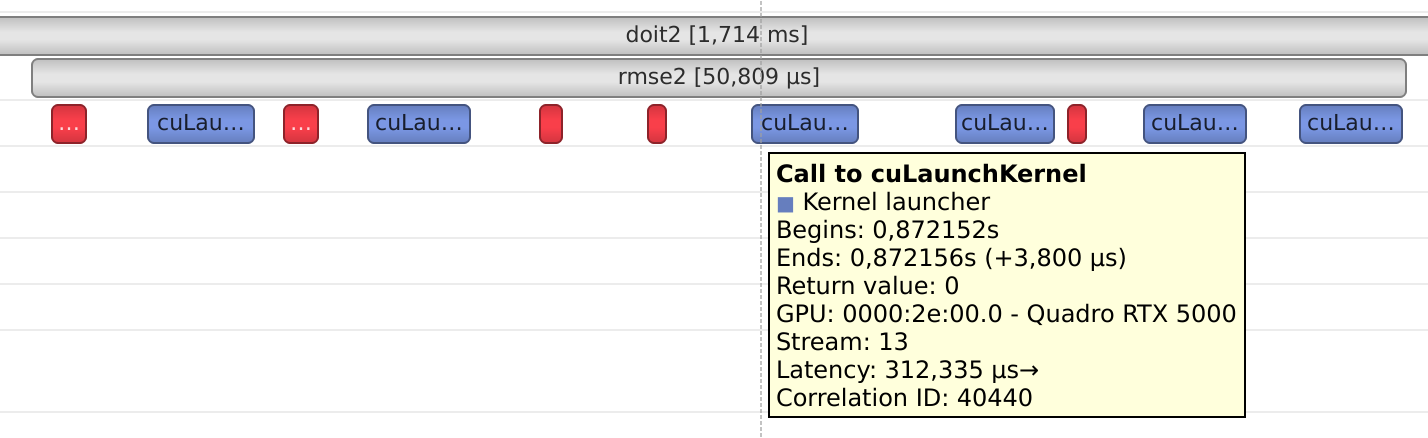

... and compare to the function using `@captured`:

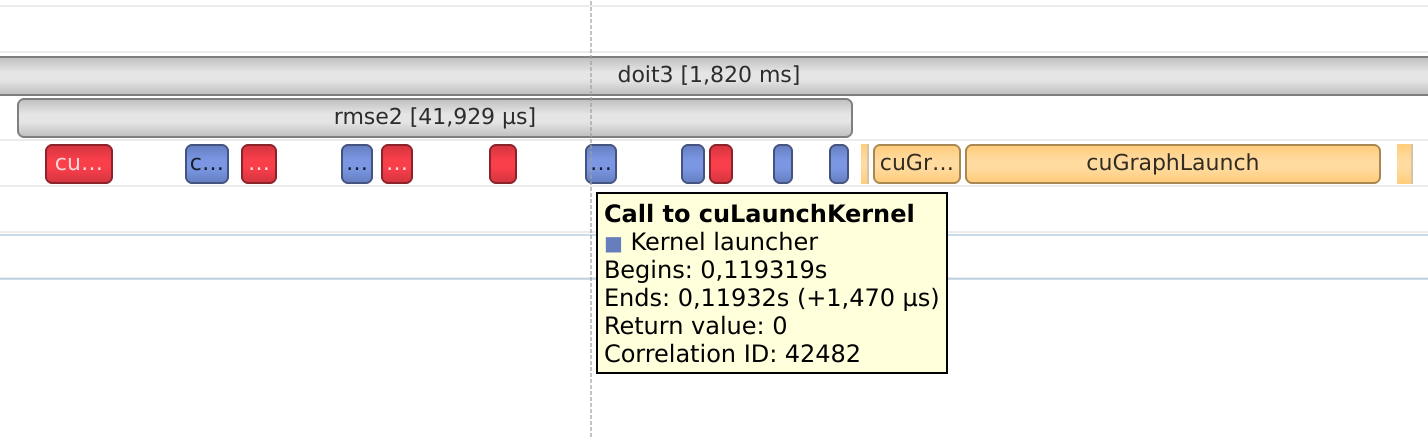

It is of note that although the final performance did not improve, individual API calls now execute much faster, so depending on the application characteristics this may lead to a performance improvement.

The graph launch itself is also much faster than the original iteration, so if you don't need to re-record (which we do now to update the inputs to the graph) this can further speed up evaluation.

Bottom line though, the graph APIs are no silver bullet, and although they can greatly reduce launch overhead they are currently tricky to use (need to avoid unsupported operations) and may not improve performance.

### Other

The CUDA driver API offers many more functions, some of which wrapped by CUDA.jl:

- kernel management: compile, link and launch kernels; generally not directly useful for users, and exposed using the `@cuda` macro
- occupancy API: more details in the kernel optimization notebook.
- memory management: more details in a separate notebook.

Other APIs may not be wrapped by CUDA.jl, in that there aren't any specific high-level wrappers. But there is always the C API, exposing all of the CUDA driver library to user programs. In addition, the way these APIs have been wrapped makes them compatible with objects from the high-level wrappers. For example, you can pass a `CuDevice` objects to C API functions expecting a `CUdevice` handle:

In [57]:
devices()

CUDA.DeviceIterator() for 2 devices:
0. Quadro RTX 5000
1. NVIDIA GeForce GTX TITAN

In [46]:
canAccessPeer = Ref{Cint}()
CUDA.cuDeviceCanAccessPeer(canAccessPeer, CuDevice(0), CuDevice(1))
canAccessPeer[]

0

## Application libraries

Libraries like CUBLAS and CUDNN are wrapped in a similar way as the CUDA driver library, with:
- low-level C-style API
- high-level Julia functions
- integrations

For example, let's have a look at matrix multiplication given two random matrices:

In [47]:
A = CUDA.rand(Float32, 1024, 1024);
B = CUDA.rand(Float32, 1024, 1024);

To work with most of NVIDIA's libraries, you need to create a handle and pass it down to most of the library's API functions. This handle is often used to initialize the library for a specific device, configure any options, including which stream to execute on. Because of that, separate handles are required for every device and stream, so CUDA.jl manages those for you and provides a `handle()` function for most libraries:

In [48]:
CUBLAS.handle()

Ptr{Nothing} @0x0000000011c8ec10

In [49]:
fetch(@async CUBLAS.handle())

Ptr{Nothing} @0x000000002bdd3cf0

Notice that these handles are different, because we are fetching it from different tasks which use different streams.

The appropriate CUBLAS function to multiply our Float32 matrices is [`cublasSgemm`](https://docs.nvidia.com/cuda/cublas/index.html#cublas-lt-t-gt-gemm) -- actually `cublasSgemm_v2`, but that's hidden from the NVIDIA docs as the `cublas.h` header takes care of that. Invoking that function is a cumbersome operation:

In [50]:
C = similar(A, size(A, 1), size(B, 2));
CUBLAS.cublasSgemm_v2(CUBLAS.handle(), 'N', 'N',
                      size(A, 1), size(B, 2), size(A, 2),
                      1f0, A, stride(A, 2),
                           B, stride(B, 2),
                      0f0, C, stride(C, 2))
Array(A)*Array(B) ≈ Array(C)

true

CUDA.jl simplifies this operation by providing [a `gemm!` function](https://github.com/JuliaGPU/CUDA.jl/blob/9f2ca663406e16274933013390df7cc44138ab99/lib/cublas/wrappers.jl#L762-L805) in the CUBLAS module, greatly improving usability of this operation by:

- using multiple dispatch to select the appropriate C function
- accepting array-values inputs which can be used to determine the size, leading dimension, element type, ...
- checking for common errors like mismatched array sizes, and verifying the function succeeded

In [51]:
CUBLAS.gemm!('N', 'N', 1f0, A, B, 0f0, C)
Array(A)*Array(B) ≈ Array(C)

true

Since there is a standardized interface for performing matrix multiplications in Julia, CUDA.jl integrates with the LinearAlgebra standard library and implements a much more familiar interface:

In [52]:
using LinearAlgebra
mul!(C, A, B)
Array(A)*Array(B) ≈ Array(C)

true

## NVIDIA Management Library

One last noteworthy library that CUDA.jl supports, is [NVML](https://docs.nvidia.com/deploy/nvml-api/index.html). Where the driver API already exposes properties of the device that matter to GPU computing (like the launch configuration, memory configuration, etc), with NVML it's possible to inspect lower-level hardware properties and even modify the system configuration.

For example, to inspect the current device:

In [53]:
cuda_dev = device()
nvml_dev = NVML.Device(parent_uuid(cuda_dev))

NVML.Device(1): Quadro RTX 5000

Note that the device index of NVML *does* match that of `nvidia-smi`, as both tools use PCI-ordering.

We can now query some interesting device properties:

In [54]:
NVML.power_usage(nvml_dev) # in watt

51.409

In [55]:
NVML.utilization_rates(nvml_dev) # in percent

(compute = 0.05, memory = 0.04)

In [56]:
NVML.compute_processes(nvml_dev)

Dict{Int64, NamedTuple{(:used_gpu_memory,), Tuple{Int64}}} with 1 entry:
  3290 => (used_gpu_memory = 1106247680,)

Since this is a system-level library that's of not much use to most users, the wrappers are underdeveloped and you will have to use the C API for many queries.